# Curvature Compression: Baseline Tests

In this notebook, we give a guided tour on the advantage of curvature compression for choosing a linear model for manifold data

In [2]:
# %matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Generate manifold data

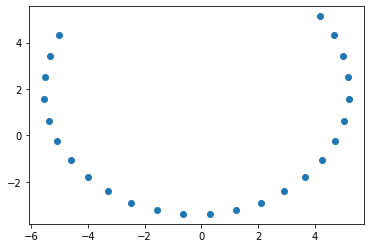

In [108]:
# dimension of data
d = 2
# number of samples
n = 25
# variance of noise
eps2 = 0
# determine if we should randomly rotate
rotate=False


# 2D manifold in 4D space

# sqrt_n = 25
# n = sqrt_n**2

# Z = np.zeros((d,n))
# for i in range(sqrt_n):
# 	for j in range(sqrt_n):
# 		x = (-0.5 + (i+1)/sqrt_n)*2*np.pi
# 		y = (-0.5 + (j+1)/sqrt_n)*2*np.pi
# 		Z[0,j + sqrt_n*i] = x
# 		Z[1,j + sqrt_n*i] = y
# 		Z[2,j + sqrt_n*i] = np.sin(4*x)
# 		Z[3,j + sqrt_n*i] = np.sin(7*y)


# # mean center
# Z = Z - np.mean(Z,axis=1,keepdims=True)
# # global normalization
# Z = Z * n / np.sqrt(np.sum(np.power(Z, 2)))

# plt.scatter(Z[0,:], Z[1,:])
scale=2
Z = np.zeros((d,n))
for i in range(n):
	x = (-0.5 + (i+1)/n)*2*np.pi
	Z[0,i] = x
	# Z[1,i] = scale*np.sin(x)
	Z[1,i] = scale*np.sin(x) + scale/2*np.sin(3*x + 1.5)

Z = np.zeros((d,n))
for i in range(n):
	x = (1.5 - 1.4/2 +1.4*(i+1)/n)*np.pi
	Z[0,i] = np.cos(x)
	# Z[1,i] = scale*np.sin(x)
	Z[1,i] = np.sin(x)

# add noise
Z = Z + eps2*np.random.randn(d, n)


# center and scale
Z_mean_orig = Z.mean(axis=1,keepdims=True)
Z = Z - Z_mean_orig
Z_norm_orig = np.linalg.norm(Z, 'fro')
Z = Z * n / Z_norm_orig

# random rotation, preserves centering and scale
if rotate:
	A = np.random.randn(d,d)
	u,s,vt = np.linalg.svd(A)
	Z = u@Z

# Z = Z[:,8:12]
plt.scatter(Z[0,:], Z[1,:])

# PCA on manifold data

Showing the linear component PCA would choose to eliminate. Note it does not give the proper elimination

[-0.92920682  0.36956013]


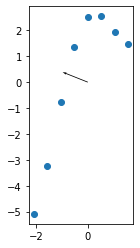

In [31]:
u, s, vt = np.linalg.svd(Z)
u_min = u[:,1]
print(u_min)

# scale to look nice on graph
u_show = u_min * np.min(np.max(np.abs(Z), axis=1))/2

plt.scatter(Z[0,:], Z[1,:])
plt.quiver(0, 0, u_show[0], u_show[1],scale_units='xy', angles='xy',scale=1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

We would idealy get a vector in the span of $(0,1)$, since all extraneous curvature is in the $y$-direction. As can be seen, the direction of least variance does not necessarily correspond to the best direction to compress curvature.

# Curvature compression on manifold data

We now test our new proposed method, curvature compression. The function we theoretically want to optimize for is the following:

$$v_* = \argmin_{\|v\|_2 = 1} \max_{x, y \in Z \mid x \ne y} |\langle v, \frac{x-y}{\|x-y\|_2}\rangle|$$
$$= \argmin_{\|v\|_2 = 1} \|\langle v, \frac{x-y}{\|x-y\|_2}\rangle\|_\infty. $$

However, since the $L^\infty$ norm is hard to directly optimize, we settle for a smooth surrogate norm: the $L^4$-norm.

In [76]:
# PyTorch model to optimize our custom loss
class CurvatureElimination(nn.Module):

    def __init__(self, X, u_0):
        super(CurvatureElimination, self).__init__();
        # data
        self.X = X
        # construct edm and gamma weight matrix
        gram = X.T@X
        edm = torch.diag(gram).reshape((n,1))@torch.ones((1,n)) \
                + torch.ones((n,1))@torch.diag(gram).reshape((1,n)) \
                - 2*gram

        # diagonal weights don't matter, set to 1 as convention
        self.gamma = torch.divide(torch.Tensor([1]),torch.eye(n) + edm)
        # projection vec
        self.u = nn.Parameter(u_0)

    def forward(self):
        U_stacked = torch.ones(self.X.shape)*self.u
        A = (self.X.T @ U_stacked - U_stacked.T @ self.X)*self.gamma
        return 0.5*A.pow(4).sum()

# PyTorch model to optimize our custom loss
class CurvatureEliminationPieces(nn.Module):

    def __init__(self, X, u_0):
        super(CurvatureEliminationPieces, self).__init__();
        # data
        self.X = X
        # construct edm and gamma weight matrix
        gram = X.T@X
        edm = torch.diag(gram).reshape((n,1))@torch.ones((1,n)) \
                + torch.ones((n,1))@torch.diag(gram).reshape((1,n)) \
                - 2*gram

        # diagonal weights don't matter, set to 1 as convention
        self.gamma = torch.divide(torch.Tensor([1]),torch.eye(n) + edm)
        # projection vec
        self.u = nn.Parameter(u_0)
        self.u2 = nn.Parameter(u_0)
        self.u3 = nn.Parameter(u_0)

    def forward(self):
        U_stacked = torch.ones(self.X[:,:13].shape)*self.u
        A = (self.X[:,:13].T @ U_stacked - U_stacked.T @ self.X[:,:13])*self.gamma[:13,:13]
        U_stacked2 = torch.ones(self.X[:,7:16].shape)*self.u2
        A2 = (self.X[:,7:16].T @ U_stacked2 - U_stacked2.T @ self.X[:,7:16])*self.gamma[7:16,7:16]
        U_stacked3 = torch.ones(self.X[:,13:].shape)*self.u3
        A3 = (self.X[:,13:].T @ U_stacked3 - U_stacked3.T @ self.X[:,13:])*self.gamma[13:,13:]
        return 0.5*(A.pow(4).sum() + A2.pow(4).sum() + A3.pow(4).sum()) - 2*((self.u.T@self.u2).pow(2) + (self.u2.T@self.u3).pow(2))

In [77]:
# optimize via projected gradient descent

u_0 = torch.randn((d,1))
u_0 = u_0 / torch.sqrt(u_0.pow(2).sum())
X = torch.Tensor(Z)

cc = CurvatureEliminationPieces(X, u_0)
opt = optim.SGD(cc.parameters(), lr=0.01)

for i in range(1000):
	cc.zero_grad()
	# forward call of LinFlow
	loss = cc()

	loss.backward()

	# compute Riemannian gradient
	egrad = cc.u.grad.detach()
	base = cc.u.data.detach()
	base = base / torch.sqrt(base.pow(2).sum())
	rgrad = egrad - base@base.t()@egrad
	# GD step
	opt.step()
	# renormalization step
	with torch.no_grad():
		cc.u.data = cc.u.data / torch.sqrt((cc.u.data).pow(2).sum());
		cc.u2.data = cc.u2.data / torch.sqrt((cc.u2.data).pow(2).sum());
		cc.u3.data = cc.u3.data / torch.sqrt((cc.u3.data).pow(2).sum());

	# determine if we have converged
	gradnorm = torch.linalg.norm(rgrad)
	if gradnorm < 5e-5:
		# print(f'converged in {i} steps!')
		# break
		pass
	if i%100 == 0:
		print(f'g step {i}: {gradnorm}')

print('done!')

g step 0: 4.956362724304199
g step 100: 0.0001570887106936425
g step 200: 1.0662403155947686e-06
g step 300: 1.0662403155947686e-06
g step 400: 1.0662403155947686e-06
g step 500: 1.0662403155947686e-06
g step 600: 1.0662403155947686e-06
g step 700: 1.0662403155947686e-06
g step 800: 1.0662403155947686e-06
g step 900: 1.0662403155947686e-06
done!


learned compression direction: [[0.7638523 0.6453911]]


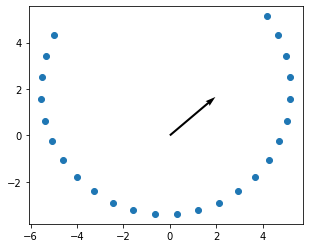

In [80]:
# show learned compression direction
u_cc = cc.u.data.detach().clone().numpy()

print(f'learned compression direction: {u_cc.T}')
# scale to look nice on graph
u_show = u_cc * np.min(np.max(np.abs(Z), axis=1))/2

plt.scatter(Z[0,:], Z[1,:])
# plt.scatter(Z[0,3], Z[1,3],c='r')
# plt.scatter(Z[0,11], Z[1,11],c='r')
# plt.scatter(Z[0,18], Z[1,18],c='r')
plt.quiver(0, 0, u_show[0], u_show[1],scale_units='xy', angles='xy',scale=1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [80]:
maxval = 0
for i in range(8):
	for j in range(8):
		if i != j:
			if np.abs(u_cc.T@(Z[:,i]-Z[:,j]) / np.linalg.norm(Z[:,i]-Z[:,j]))  > maxval:
				maxval = u_cc.T@(Z[:,i]-Z[:,j])/ np.linalg.norm(Z[:,i]-Z[:,j])
		

print(f'max correlation from computed vec:{maxval}')

u_new = np.zeros((2,1))
u_new[1] = 1
u_new[0] = 0
u_new = u_new / np.linalg.norm(u_new)
maxval = 0
for i in range(8):
	for j in range(8):
		if i != j:
			if np.abs(u_new.T@(Z[:,i]-Z[:,j])/ np.linalg.norm(Z[:,i]-Z[:,j])) > maxval:
				maxval = u_new.T@(Z[:,i]-Z[:,j])/ np.linalg.norm(Z[:,i]-Z[:,j])
		

print(f'max correlation from (0,1):{maxval}')

U_stacked = np.ones(Z.shape)*u_cc
A = (Z.T @ U_stacked - U_stacked.T @ Z)*cc.gamma.detach().cpu().numpy()
print(0.5*np.sum(np.power(np.abs(A),4)))

U_stacked = np.ones(Z.shape)*u_new
A = (Z.T @ U_stacked - U_stacked.T @ Z)*cc.gamma.detach().cpu().numpy()
print(0.5*np.sum(np.power(np.abs(A),4)))

max correlation from computed vec:[0.99997612]
max correlation from (0,1):[0.9779004]
1.2709237855047824
2.18593293457326


# Step 2
find global positioning for each piece

In [94]:
# softmax parameter
gamma = 0.5

# PyTorch model to optimize our custom loss
class AlignmentPieces(nn.Module):

    def __init__(self, X, u, u2, u3, alpha_0):
        super(AlignmentPieces, self).__init__();
        self.X = X	

        # get softmax coefficients
        v1 = X[:,[8]]
        v2 = X[:,[12]]
        v3 = X[:,[16]]

        # vectors of square distances
        dists1 = (X-v1).pow(2).sum(axis=0)
        dists2 = (X-v2).pow(2).sum(axis=0)
        dists3 = (X-v3).pow(2).sum(axis=0)

        dists_vec = torch.vstack((dists1,dists2,dists3))
        self.probs = nn.Softmax(dim=0)(-gamma*dists_vec)

        # projection vec
        self.u = u
        # self.alpha = nn.Parameter(alpha_0)
        self.u2 = u2
        self.alpha2 = nn.Parameter(alpha_0.clone())
        self.u3 = u3
        self.alpha3 = nn.Parameter(alpha_0.clone())

    def forward(self):
        # to eliminate redunancy, enforce first alpha to be 0
        Xproj1 = self.X - self.u@self.u.T@self.X
        Xproj2 = self.X - self.u2@self.u2.T@self.X + self.alpha2*self.u2
        Xproj3 = self.X - self.u3@self.u3.T@self.X + self.alpha3*self.u3

        E_Xproj = self.probs[[0],:]*Xproj1 + self.probs[[1],:]*Xproj2 + self.probs[[2],:]*Xproj3
        Var_X = self.probs[[0],:]*(Xproj1 - E_Xproj).pow(2).sum(axis=0) + self.probs[[1],:]*(Xproj2 - E_Xproj).pow(2).sum(axis=0) + self.probs[[2],:]*(Xproj3 - E_Xproj).pow(2).sum(axis=0)
        return Var_X.sum()
        

In [95]:
align = AlignmentPieces(torch.Tensor(Z), cc.u.data, cc.u2.data, cc.u3.data, torch.Tensor([1]))
opt = optim.SGD(align.parameters(), lr=0.1)

for i in range(50000):
	align.zero_grad()
	# forward call of LinFlow
	loss = align()
	loss.backward()

	# GD step
	opt.step()

	# determine if we have converged
	gradnorm = torch.sqrt(align.alpha2.grad.detach().pow(2) + align.alpha3.grad.detach().pow(2))
	if gradnorm < 5e-5:
		# print(f'converged in {i} steps!')
		# break
		pass
	if i%1000 == 0:
		# print(f'g step {i}: {gradnorm}')
		print(f'data {align.alpha2.data}, {align.alpha3.data}. loss {loss}')
		# print(align.alpha2.data)
		# print(align.alpha3.data)

print('done!')

data tensor([0.6930]), tensor([1.0843]). loss 6.627694606781006
data tensor([-1.6579]), tensor([2.8709]). loss 1.7598663568496704
data tensor([-1.6579]), tensor([2.8709]). loss 1.7598663568496704
data tensor([-1.6579]), tensor([2.8709]). loss 1.7598663568496704
data tensor([-1.6579]), tensor([2.8709]). loss 1.7598663568496704


KeyboardInterrupt: 

In [96]:
v1 = Z[:,[4]]
v2 = Z[:,[12]]
v3 = Z[:,[20]]

for i in range(n):
	dists = np.zeros(3)
	dists[0] = np.linalg.norm(Z[:,i] - v1)
	dists[1] = np.linalg.norm(Z[:,i] - v2)
	dists[2] = np.linalg.norm(Z[:,i] - v3)
	if np.argmin(dists) == 0:
		print(i)
		

# plot

[0.9160609 0.0542517 0.0296874]
[0.93651615 0.04541842 0.01806543]
[0.95012564 0.03862679 0.01124757]
[0.95927607 0.03351178 0.00721215]
[0.96546808 0.02974424 0.00478769]
[0.92543584 0.0664506  0.00811357]
[0.84254679 0.14390616 0.01354705]
[0.69333333 0.2855586  0.02110807]
[0.48562011 0.48562011 0.02875979]
[0.28202854 0.68476239 0.03320907]
[0.14098686 0.82545477 0.03355837]
[0.06487947 0.90355532 0.03156521]
[0.02902    0.94196001 0.02902   ]
[0.03156521 0.90355532 0.06487947]
[0.03355837 0.82545477 0.14098686]
[0.03320907 0.68476239 0.28202854]
[0.02875979 0.48562011 0.48562011]
[0.02110807 0.2855586  0.69333333]
[0.01354705 0.14390616 0.84254679]
[0.00811357 0.0664506  0.92543584]
[0.00478769 0.02974424 0.96546808]
[0.00721215 0.03351178 0.95927607]
[0.01124757 0.03862679 0.95012564]
[0.01806543 0.04541842 0.93651615]
[0.0296874 0.0542517 0.9160609]


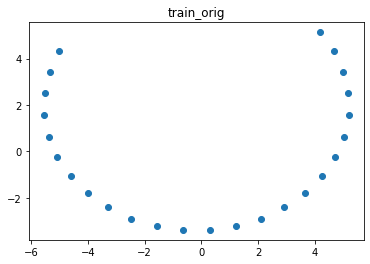

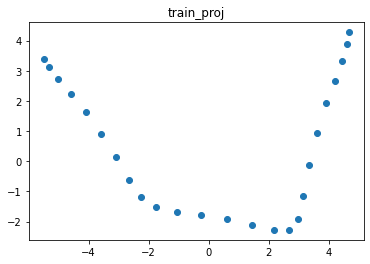

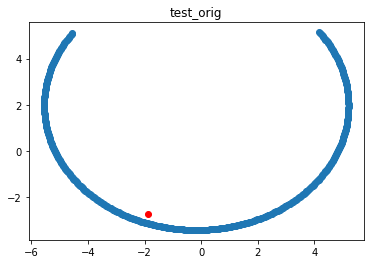

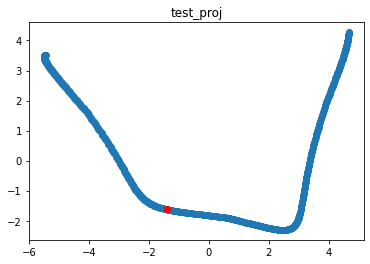

In [122]:
u1 = cc.u.detach().clone().cpu().numpy()
A1_proj = np.eye(d) - u1@u1.T
u2 = cc.u2.detach().clone().cpu().numpy()
A2_proj = np.eye(d) - u2@u2.T
u3 = cc.u3.detach().clone().cpu().numpy()
A3_proj = np.eye(d) - u3@u3.T

alpha2 = align.alpha2.detach().clone().cpu().numpy()
alpha3 = align.alpha3.detach().clone().cpu().numpy()

Z_new = np.zeros(Z.shape)
for i in range(n):
	z_vec = Z[:,[i]]
	# compute local components
	proj1 = A1_proj@z_vec + -2*u1
	proj2 = A2_proj@z_vec + alpha2*u2
	proj3 = A3_proj@z_vec + alpha3*u3
	# softmax
	dist1 = np.linalg.norm(z_vec - v1)
	dist2 = np.linalg.norm(z_vec - v2)
	dist3 = np.linalg.norm(z_vec - v3)

	probs = np.array([np.exp(-gamma*dist1), np.exp(-gamma*dist2), np.exp(-gamma*dist3)])
	probs = probs/probs.sum()
	print(probs)

	z_new = proj1*probs[0] + proj2*probs[1] + proj3*probs[2]
	Z_new[:,[i]] = z_new


plt.scatter(Z[0,:], Z[1,:])
plt.title('train_orig')
plt.show()
plt.scatter(Z_new[0,:], Z_new[1,:])
plt.title('train_proj')
plt.show()

scale=2
n_test = 500
Z_test = np.zeros((d,n_test))
for i in range(n_test):
	x = (1.5 - 1.4/2 +1.4*(i+1)/n_test)*np.pi
	Z_test[0,i] = np.cos(x)
	# Z[1,i] = scale*np.sin(x)
	Z_test[1,i] = np.sin(x)


# center and scale (TO ORIGINAL TRAIN DATA)
Z_test = Z_test - Z_mean_orig
Z_test = Z_test * n / Z_norm_orig

# see what mapping is like on test data
test_point = Z_test[:,[250]] + 1*np.random.randn(2,1)

plt.scatter(Z_test[0,:], Z_test[1,:])
plt.scatter(test_point[0,:], test_point[1,:], color='red')
plt.title('test_orig')
plt.show()



for i in range(n_test):
	z_vec = Z_test[:,[i]]
	# compute local components
	proj1 = A1_proj@z_vec -2*u1
	proj2 = A2_proj@z_vec + alpha2*u2
	proj3 = A3_proj@z_vec + alpha3*u3
	# softmax
	dist1 = np.linalg.norm(z_vec - v1)
	dist2 = np.linalg.norm(z_vec - v2)
	dist3 = np.linalg.norm(z_vec - v3)

	probs = np.array([np.exp(-gamma*dist1), np.exp(-gamma*dist2), np.exp(-gamma*dist3)])
	probs = probs/probs.sum()

	z_new = proj1*probs[0] + proj2*probs[1] + proj3*probs[2]
	Z_test[:,[i]] = z_new



# test point map
z_vec = test_point
# compute local components
proj1 = A1_proj@z_vec -2*u1
proj2 = A2_proj@z_vec + alpha2*u2
proj3 = A3_proj@z_vec + alpha3*u3
# softmax
dist1 = np.linalg.norm(z_vec - v1)
dist2 = np.linalg.norm(z_vec - v2)
dist3 = np.linalg.norm(z_vec - v3)

probs = np.array([np.exp(-gamma*dist1), np.exp(-gamma*dist2), np.exp(-gamma*dist3)])
probs = probs/probs.sum()

z_new = proj1*probs[0] + proj2*probs[1] + proj3*probs[2]
f_test = z_new

plt.scatter(Z_test[0,:], Z_test[1,:])
plt.scatter(f_test[0,:], f_test[1,:], color='red')
plt.title('test_proj')
plt.show()


	